<a href="https://colab.research.google.com/github/fornitroll/Object-Detection-with-PyTorch-Kyiv-/blob/master/Lecture_2_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 2. Object Localisation

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/localisation.png?raw=true" width="500">

Today we will try to use things that we learned in the previous lecture to build some working models for the detection of pedestrians on the streets.
For this, we will use [Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/), because it's small and will not take too much time for learning and because it has segmentation masks that we need.

What we will learn in this lecture:

1. Simple Localization Model. Building Dataset, Transformation, Train and Test methods.
2. Mask Localization Model - using segmentation for detection purposes. Building Dataset, Transformation, Train and Test methods.

In [0]:
!pip install -q --upgrade pillow torch torchvision

     |████████████████████████████████| 2.1MB 2.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
# downloading dataset and two examples from internet for testing result
!wget --quiet https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!wget --quiet -O pedastrian.jpg https://www.abc.net.au/news/image/9809348-3x2-700x467.jpg
!wget --quiet -O pedastrian2.jpg https://cdn.newsapi.com.au/image/v1/d896a51a3309eb6f7c0173a1940eb1fb?width=650
!unzip PennFudanPed.zip

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotation/FudanPed00006.txt  
  inflating: PennFudanPed/Annotation/FudanPed00007.txt  
  inflating: PennFudanPed/Annotation/FudanPed00008.txt  
  inflating: PennFudanPed/Annotation/FudanPed00009.txt  
  inflating: PennFudanPed/Annotation/FudanPed00010.txt  
  inflating: PennFudanPed/Annotation/FudanPed00011.txt  
  inflating: PennFudanPed/Annotation/FudanPed00012.txt  
  inflating: PennFudanPed/Annotation/FudanPed00013.txt  
  inflating: PennFudanPed/Annotation/FudanPed00014.txt  
  inflating: PennFudanPed/Annotation/FudanPed00015.txt  
  i

In [0]:
import time
import os
import sys

import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFile
# fix bugs with loading png files
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, Subset, random_split

from google.colab import files
def upload(path):
    uploaded = files.upload()
    with open(path,'wb') as fp:
        fp.write(uploaded[list(uploaded.keys())[0]])
 
def download(path):
    files.download(path)

After we download our dataset and unzip it to ./PennFudanPed we need to implement Dataset class to make interaction with the dataset simpler.

We have 3 methods to implement: `__init__`, `__getitem__`, `__len__`

For bounding box we will use 2 points - TopLeft and BottomRight, the same format has dataset annotation

In [0]:
class PennFudanDataset(Dataset):
    def __init__(self, root, transforms=None):
        # path to the dataset
        self.root = root
        # transformation for image and targets
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        '''This method return one time(not batch), image and target'''
        
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        # get bounding box coordinates for one mask other paint over
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            # As we talking about single object localisation, then we need to
            # remove all other objects on image, so just fill them
            if i == 0:
                boxes.append([xmin, ymin, xmax, ymax])
            elif i > 0:
                # paint over other objects with gray color
                d = ImageDraw.Draw(img)
                d.rectangle([xmin, ymin, xmax, ymax], fill=(200,200,200))
                
        targets = boxes[0]
            
        if self.transforms is not None:
            img, targets = self.transforms(img, targets)

        return img, targets

    def __len__(self):
        '''this method return len of dataset'''
        return len(self.imgs)

## Coordinates localization model

For our task, we need to convert images to some fixed size, and because we also have bounding boxes we need to implement resizing for them, cause base transforms working only with images and tensors.

All models in torchvision use these params for image normalization:
```
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
```
They got from ImageNet Dataset, which counts 17M images. So we can use them instead of running mean and std over the whole dataset.



In [0]:
class LocTransform:
    def __init__(self,size=(512,512), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.size = size
        # base transform for images
        self.img_ts = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(), # converts to [0,1] interval
            transforms.Normalize(mean=mean, std=std)
        ])        
        
    def box_resize(self, img_shape, box):
        """Method to resize bounding box"""
        w,h = img_shape
        # get scale
        xs,ys = self.size[0]/w, self.size[1]/h
        # resize box coord by scale
        box = np.array([box[0]*xs/self.size[0],box[1]*ys/self.size[1],box[2]*xs/self.size[0],box[3]*ys/self.size[1]])
        return torch.as_tensor(box, dtype=torch.float32)
        
    def __call__(self, img, target=None):
        x = self.img_ts(img)
        if target:
            y = self.box_resize(img.size,target)
            return x,y
        return x

**!!!** By the experience of many developers with whom I talked, a typical place for bugs in the solutions is in generating and modifying input data. So before you start your training process always check that your input pipelines work correctly.

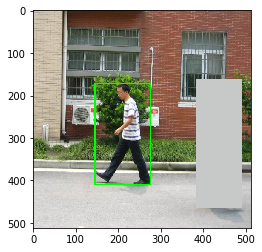

(512, 512, 3)


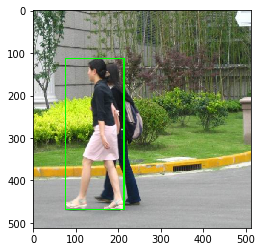

(512, 512, 3)


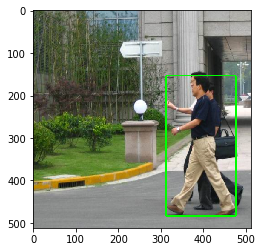

(512, 512, 3)


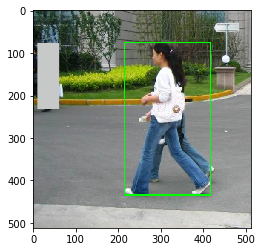

(512, 512, 3)


In [0]:
ts = LocTransform()
dg = PennFudanDataset('./PennFudanPed', ts)
size = 512
def denorm(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return (x * std) + mean
for i in range(4):
    img, t = dg[i]
    img = (denorm(img.numpy().transpose(1,2,0).copy())*255).astype(np.uint8)
    t = t*size
    img = cv2.rectangle(img, (t[0],t[1]), (t[2], t[3]), (0, 255, 0), 2)
    plt.imshow(img)
    plt.show()
    print(img.shape)

So all things are working fine and we can proceed to write our model.

As training whole model can take much time and also doing this on the small dataset is not a good idea, we will use the transfer learning technique(use pre-trained model as part of our solution that was trained on similar data).

Typical structure for multi-class localization model looks like this:
<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/LocalizationArch.png?raw=true" width="700">

Heads can be both FullyConv or Dense depends on the structure of the model. The base model also called the Backbone model 

We will use the ResNet18 model, so let's look at its structure to see where we should cut it.

In [0]:
resnet18 = models.resnet18(pretrained=True)
print(list(resnet18.children()))

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

torch.Size([1, 512, 16, 16])

We see that the last two blocks are used for classification, and we need only feature extraction(all things before that). So we need to cut off the last two layers: AdaptiveAvgPool2d, Linear

In [0]:
class LocalizationModel(nn.Module):
    def __init__(self):
        super(LocalizationModel, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        # this will make output of shape [1, 512, 16, 16]
        self.base = nn.Sequential(*list(resnet18.children())[:-2])
        # if we want to freeze parameters of base models and train only our overhead
        # for param in self.base.parameters():
        #     param.requires_grad = False

        # add some additional layers to improve memory of the network
        # this will make output of shape [1, 64, 12, 12]
        self.head = nn.Sequential(
            # this convolution will make result smaller size
            # if you dont want this, you should add padding explicitly before 
            # each layer
            nn.Conv2d(512,256,3),
            nn.ReLU(),
            nn.Conv2d(256,64,3),
            nn.ReLU(),
            # in many cases you will see here something like MaxPooling,
            # but pooling layers killing information which is giving worse 
            # result then not using them. Reason why they can be used is to save 
            # time
        )
        # our localization blocks 
        self.loc = nn.Sequential(
            nn.Linear(64*12*12,256),
            nn.ReLU(),
            # some small regularization, to decrease overfit
            nn.Dropout(0.5),
            nn.Linear(256,4),
            nn.Sigmoid() # [0,1] result as we use relative coordinates
        )
    
    def forward(self, x):
        x = self.base(x)
        x = self.head(x).view(-1,64*12*12)
        x = self.loc(x)
        return x

In [0]:
# check our model
m = LocalizationModel()
list(m.children())

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
 

In [0]:
# if you like model summary like in Keras
# pip install torchsummary
from torchsummary import summary
summary(LocalizationModel(), input_size=(3, 512, 512), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

### IoU - Intersection over Union
Standart metric that used to calculate the accuracy of the bounding box prediction.

The only thing that you should always remember is that your prediction depends on the quality dataset markup. If markup not very accurate, then you should push your network to give bigger IoU results. 

Here is how it's calculated

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/iou_equation.png?raw=true" width="300"/>

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/iou_overlap_region.png?raw=true">

In [0]:

def iou(X,Y, epsilon=1e-5):
    """ Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.

    Args:
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (float) The Intersect of Union score.
    """
    bs,_ = X.shape
    res = []
    for i in range(bs):
        a,b = X[i],Y[i]
        # COORDINATES OF THE INTERSECTION BOX
        x1 = max(a[0], b[0])
        y1 = max(a[1], b[1])
        x2 = min(a[2], b[2])
        y2 = min(a[3], b[3])

        # AREA OF OVERLAP - Area where the boxes intersect
        width = (x2 - x1)
        height = (y2 - y1)
        # handle case where there is NO overlap
        if (width<0).any() or (height <0).any():
            res.append(0.0)
        area_overlap = width * height

        # COMBINED AREA
        area_a = (a[2] - a[0]) * (a[3] - a[1])
        area_b = (b[2] - b[0]) * (b[3] - b[1])
        area_combined = area_a + area_b - area_overlap

        # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
        iou = abs(area_overlap / (area_combined+epsilon))
        res.append(iou)
        
    return np.mean(np.abs(np.array(res)))

Now let's train our model for 20 epochs (there are only 42 batches)

In [0]:
torch.manual_seed(42)

ts = LocTransform()

ds = PennFudanDataset('./PennFudanPed', ts)

loader = DataLoader(ds, batch_size=4, pin_memory=True, drop_last=True) 
epochs = 20

device = torch.device("cuda")
model = LocalizationModel()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5)
st = time.time()
model.train()
for e in range(epochs):
    t = 0
    loss_avg = 0
    iou_avg = 0
    for i, (img, target) in enumerate(loader):
        img = img.to(device)
        target = target.to(device)
        
        # before each iteration we clear all gradients calculated before 
        optimizer.zero_grad()
        output = model(img)
        loss = F.mse_loss(output, target)
        # calculating gradients
        loss.backward()
        # optimizing
        optimizer.step()
        # .item() is simple way to get value from scalar
        loss_avg += loss.item()
        # detach - returns new tensor detached from computation graph
        # to get data from gpu first we need to move it to cpu
        iou_avg += iou(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        t += 1
    print(f'Epoch: {e}/{epochs} Loss:{loss_avg/t} IoU:{iou_avg/t}')
    # saving state of the model
    torch.save(model.state_dict(), 'loc.pth')
print('Training time:', time.time()-st)

Epoch: 0/20 Loss:0.052563193320695846 IoU:0.14346000054306932
Epoch: 1/20 Loss:0.03237954094739897 IoU:0.20426945055552834
Epoch: 2/20 Loss:0.02302811693932329 IoU:0.253250006355397
Epoch: 3/20 Loss:0.013042683219758882 IoU:0.35322933920953714
Epoch: 4/20 Loss:0.010763584613977443 IoU:0.41939116644426566
Epoch: 5/20 Loss:0.007597744747597192 IoU:0.48109405312135456
Epoch: 6/20 Loss:0.006479030009359121 IoU:0.49900234578657543
Epoch: 7/20 Loss:0.006286755245777645 IoU:0.5256832917204189
Epoch: 8/20 Loss:0.005774131904001392 IoU:0.5338983705106389
Epoch: 9/20 Loss:0.0050739501492075975 IoU:0.5481345176987424
Epoch: 10/20 Loss:0.0041515384939321805 IoU:0.573869554555557
Epoch: 11/20 Loss:0.004358982886298604 IoU:0.5593993009495088
Epoch: 12/20 Loss:0.0037056021503217166 IoU:0.5735984198264397
Epoch: 13/20 Loss:0.00378805353760808 IoU:0.5684230721196295
Epoch: 14/20 Loss:0.00338508156848894 IoU:0.5966329798689552
Epoch: 15/20 Loss:0.0034924098373656826 IoU:0.5668835557023643
Epoch: 16/20 L

In [0]:
def test(model_path, model_class, input, num=30, size=(512,512), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    state = torch.load(model_path)
    model = model_class()
    model.load_state_dict(state)
    # don't forget about this in other case Dropouts, BatchNorms, etc will not 
    # work correctly
    model.eval()
    img_ts = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(), # converts to [0,1] interval
        transforms.Normalize(mean=mean, std=std)
    ])  
    t = 0
    iou_avg = 0
    if isinstance(input, Image.Image):
        input = [[input, None]]
    for img, target in input:
        img_t = img_ts(img)
        img_t = img_t.view((1,)+img_t.shape)
        st = time.time()
        res = model(img_t)
        if not target:
            print('Inference time:', time.time()-st)
        if not target:
            # also lets get activation from base layers
            activation_mask = model.base(img_t).detach().numpy()[0].mean(axis=0)
        xmin, ymin, xmax, ymax = res.detach().numpy()[0]
        w,h = img.size
        if target:
            _iou = iou(np.array([[int(xmin*w), int(ymin*h), int(xmax*w), int(ymax*h)]]), np.array([target]))
            iou_avg += _iou
            t += 1
        if t >= num:
            break
    if target:
        print('AVG IoU: ', iou_avg/t)
    else:
        print(res)
        d = ImageDraw.Draw(img)
        d.rectangle([int(xmin*w), int(ymin*h), int(xmax*w), int(ymax*h)], outline=(0,255,0), width=3)
        plt.imshow(img)
        plt.show()
        plt.imshow(activation_mask)
        plt.show()


AVG IoU:  0.6972219259609174
Inference time: 0.4152491092681885
tensor([[0.4446, 0.2562, 0.6214, 0.8855]], grad_fn=<SigmoidBackward>)


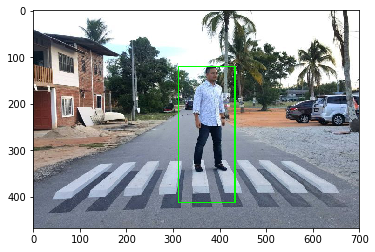

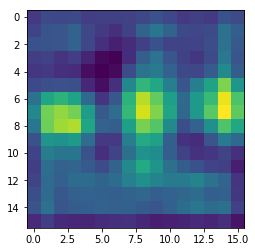

Inference time: 0.424283504486084
tensor([[0.3551, 0.1728, 0.6009, 0.9172]], grad_fn=<SigmoidBackward>)


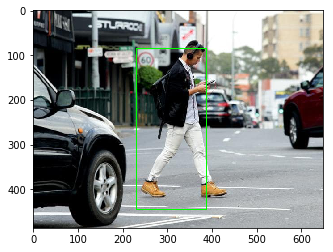

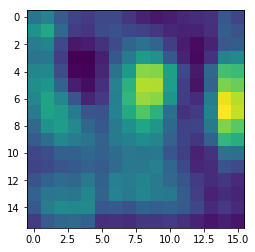

Inference time: 0.42743825912475586
tensor([[0.3760, 0.3451, 0.5687, 0.8653]], grad_fn=<SigmoidBackward>)


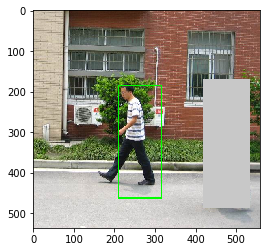

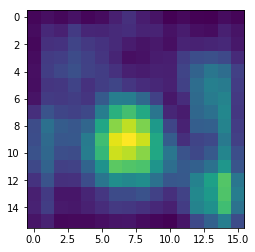

Inference time: 0.41004300117492676
tensor([[0.1869, 0.2028, 0.4542, 0.9377]], grad_fn=<SigmoidBackward>)


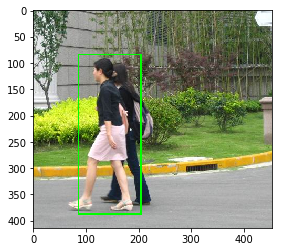

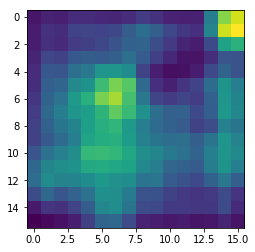

Inference time: 0.4239530563354492
tensor([[0.6280, 0.2921, 0.8992, 0.9344]], grad_fn=<SigmoidBackward>)


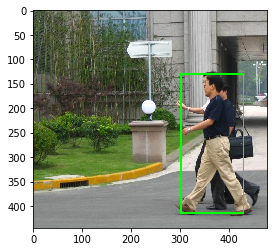

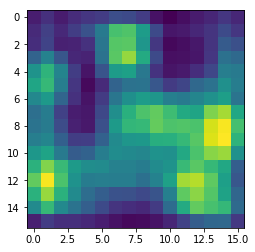

In [0]:
dd = PennFudanDataset('./PennFudanPed', None)
# mean IoU (30 dataset images)        
test('loc.pth',LocalizationModel,dd)

# testing images out from dataset
test('loc.pth',LocalizationModel,Image.open('pedastrian.jpg').convert("RGB") )
test('loc.pth',LocalizationModel,Image.open('pedastrian2.jpg').convert("RGB") )

# dataset images
test('loc.pth',LocalizationModel,dd[0][0])
test('loc.pth',LocalizationModel,dd[1][0])
test('loc.pth',LocalizationModel,dd[2][0])

### Result

As we can see we got pretty good accuracy of detection on train and test data even after only 5 minutes of training.

I also output the activation map of the last layer in the base module. This gives an understanding of what really sees our feature extractor network and what classes of object it trained to distinguish. And as we train our model for a not very long time we see that the model still activates with things like trees, signs, people, cars. Sometimes it can give you an understanding of what's going wrong.
</br></br>
**(x1,y1,x2,y2) VS (x,y,w,h)**

Both these formats used to describe bounding boxes. But there is a difference in them.

Convolutions are not very good to make hard mathematics operation prediction, Fully-Connected networks here are much better. 

Both of these variants will work, but the question is what is faster for training and simpler.

So we get 2 questions here:
1. How better predict these numbers
2. How to normalize them


1.I mean prediction from the side of CNN. While points x1,y1 or cx,cy can be detected simply by position on activation map, the w,h are metrics and thus predicting such data can be harder for the network.

2.We can't give any numbers to the network. The deeper and complicated the network we have the more normalization of data is matters. Thus we need good ways of normalizing the data. Currently, we have simple normalization making data relative to image size, but in the next lectures, it will change.

That's why the first variant will make life simpler for this current model during the training. And also you can use a small hack like CoordConv, which is basically two index layers that have points numbering from 0 to width, and from 0 to height. In such a way network better understand the position. [You can read more here](https://eng.uber.com/coordconv/)

</br>

And all these things move us to the second way how we can detect objects without using coordinates and metrics at all - just switch detection problem to instance segmentation problem. This task is much natural for convolution networks to cause segmentation and activations are basically the same, CNN network doing segmentation all the time by pattern matching. Thus it makes work simpler cause the network doesn't need to convert activation masks to coordinates.

Additionally, we will use the Spatial Pyramid Pooling that gives a good result on Segmentation tasks. It's a very simple technique which works very good.

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/pspnet.png?raw=true">

**Intuition behind SPP:**

In some cases in segmentation, the network can try to predict the class of image patch that doesn't have enough information for that, for example, the skin of the horse, which is similar to the skin of the cow and many other animals. So to do a correct classification network should take a much wider context that has additional information to make correct classification tasks. 

As it simplifies working with objects of different scales, cause if we want to find face it much simpler to do with a patch that covers it all, then does by small pieces.

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/c13684e9-284a-4adc-a093-eeb2a20148ab.jpg?raw=true">


## Mask localization model or Semantic image segmentation

The main task of semantic image segmentation is to label each pixel of an image with a corresponding class of what is being represented. Also, it called dense prediction as we predicting for every pixel.


Input image on the left side, and predicted image segmentation on the right side.
<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/FSO.jpg?raw=true" />

As we will predict only one class so we get the only color mask

<img src="https://github.com/learnml-today/object-detection-with-pytorch/blob/master/imgs/Annotation%202019-11-12%20195325.png?raw=true" />

So let's slightly change our model to use 2 scales from last, and previous base blocks of sizes 16x16 and 32x32.</br> And write a new Dataset class to use masks

In [0]:
class MaskLocalizationModel(nn.Module):
    def __init__(self):
        super(MaskLocalizationModel, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        self.base = nn.Sequential(*list(resnet18.children())[:-3])
        self.block = nn.Sequential(*list(resnet18.children())[-3])
        self.head = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(768,256,3),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256,64,3),
            nn.ReLU()
        )
        self.loc = nn.Sequential(
            nn.Conv2d(64,64,1),
            nn.ReLU(),
            nn.Dropout(),
            # 32x32 grid
            nn.Conv2d(64,1,1),
            nn.Sigmoid()
        )
        self.up = nn.Sequential(
            nn.Upsample((32,32)),
            nn.Conv2d(512,512,1),
            nn.ReLU()
        )
    
    def forward(self, x):
        b1 = self.base(x)
        b2 = self.block(b1)
        # upscale block to much shape with 32x32
        b2 = self.up(b2)
        # concat outputs from different layers
        x = torch.cat([b1,b2],dim=1)
        x = self.head(x)
        x = self.loc(x)
        x = x.view(-1,32,32)
        return x

In [0]:
class PennFudanGridDataset(Dataset):
    def __init__(self, root, transforms=None, grid_size=32):
        self.root = root
        self.grid_size = grid_size
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        '''This method return one time(not batch), image and target'''
        
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        out = np.zeros((num_objs, self.grid_size, self.grid_size)).astype(np.float32)
        for i in range(num_objs):
            segm = cv2.resize(masks[i].astype(np.float32), (self.grid_size,self.grid_size), interpolation=cv2.INTER_NEAREST)
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if i == 0:
                out[i] = segm
            elif i > 0:
                d = ImageDraw.Draw(img)
                d.rectangle([xmin, ymin, xmax, ymax], fill=(200,200,200))

        # convert everything into a torch.Tensor
        targets = out[0]

        if self.transforms is not None:
            img = self.transforms(img)

        return img, targets

    def __len__(self):
        '''this method return len of dataset'''
        return len(self.imgs)

Don't forget to check Dataset

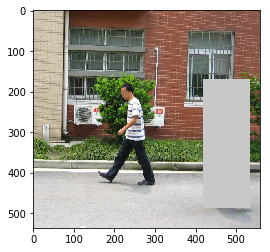

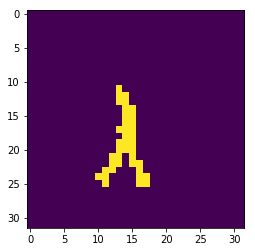

In [0]:
dg = PennFudanGridDataset('./PennFudanPed', None)
img, target = dg[0]
plt.imshow(img)
plt.show()
plt.imshow(target)
plt.show()

In [0]:
torch.manual_seed(42)

ts = LocTransform()

ds = PennFudanGridDataset('./PennFudanPed', ts)

loader = DataLoader(ds, batch_size=4, pin_memory=True, drop_last=True) 
epochs = 20

device = torch.device("cuda")
model = MaskLocalizationModel()
# state = torch.load('loc.pth')
# model.load_state_dict(state)
model = model.to(device)
# we optimizing parameters of our model, other parameters will not be optimised if exist  
optimizer = optim.Adam(model.parameters(), lr=1e-4)
st = time.time()
model.train()
for e in range(epochs):
    t = 0
    loss_avg = 0
    iou_avg = 0
    for i, (img, target) in enumerate(loader):
        img = img.to(device)
        target = target.to(device)
        # before each iteration we clear all gradients calculated before 
        optimizer.zero_grad()
        output = model(img)
        loss = F.mse_loss(output, target)
        # calculating gradients
        loss.backward()
        # optimizing
        optimizer.step()
        # .item() is simple way to get value from scalar
        loss_avg += loss.item()
        
        output = output.cpu().detach().numpy()
        target = target.cpu().detach().numpy()

        h,w = img.shape[-2:]
        grid = 32
        threshold = 0.3
        # thresholding mask by value and convert to x1,y1,x2,y2 coordinates
        # and converting mask to bounding box simply by cover it with bbox
        pos = np.where(output > threshold)
        xmin = np.min(pos[1])*w/grid
        xmax = np.max(pos[1])*w/grid
        ymin = np.min(pos[0])*h/grid
        ymax = np.max(pos[0])*h/grid

        pos = np.where(target > threshold)
        txmin = np.min(pos[1])*w/grid
        txmax = np.max(pos[1])*w/grid
        tymin = np.min(pos[0])*h/grid
        tymax = np.max(pos[0])*h/grid

        iou_avg += iou(np.array([[int(xmin), int(ymin), int(xmax), int(ymax)]]), np.array([[int(txmin), int(tymin), int(txmax), int(tymax)]]))
        t += 1
    print(f'Epoch: {e}/{epochs} Loss:{loss_avg/t} IoU:{iou_avg/t}')
    # saving state of the model
    torch.save(model.state_dict(), 'loc2.pth')
print('Training time:', time.time()-st)

Epoch: 0/20 Loss:0.07550478935064305 IoU:0.8748000844411971
Epoch: 1/20 Loss:0.036008795856365135 IoU:0.9349777142540787
Epoch: 2/20 Loss:0.024378901968399685 IoU:0.9499573868438524
Epoch: 3/20 Loss:0.016742198716937787 IoU:0.9576574399147568
Epoch: 4/20 Loss:0.014155055473869046 IoU:0.9681187554252165
Epoch: 5/20 Loss:0.012521375757863834 IoU:0.9736373965947503
Epoch: 6/20 Loss:0.011164374893442505 IoU:0.9690202260872686
Epoch: 7/20 Loss:0.009765724496295055 IoU:0.978834730659302
Epoch: 8/20 Loss:0.00858600331204278 IoU:0.9836139813867049
Epoch: 9/20 Loss:0.008261867139178017 IoU:0.9814916994433438
Epoch: 10/20 Loss:0.007277852273546159 IoU:0.9786736224299698
Epoch: 11/20 Loss:0.007084921079998215 IoU:0.979083791146744
Epoch: 12/20 Loss:0.006078017692613814 IoU:0.9875977446319035
Epoch: 13/20 Loss:0.005441541747478325 IoU:0.9859817922165255
Epoch: 14/20 Loss:0.004508573331847964 IoU:0.988182355069336
Epoch: 15/20 Loss:0.004092291399415228 IoU:0.9915042536261915
Epoch: 16/20 Loss:0.003

In [0]:
def test_mask(model_path, model_class, input, num=30, grid=32, size=(512,512), threshold=0.3, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    state = torch.load(model_path)
    model = model_class()
    model.load_state_dict(state)
    model.eval()
    img_ts = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(), # converts to [0,1] interval
        transforms.Normalize(mean=mean, std=std)
    ])  
    t = 0
    iou_avg = 0
    if isinstance(input, Image.Image):
        input = [[input, None]]
    for img, target in input:
        
        w,h = img.size
        img_t = img_ts(img)
        img_t = img_t.view((1,)+img_t.shape)
        st = time.time()
        res = model(img_t)
        if target is None:
            print('Inference time:', time.time()-st)
        mask = res.detach().numpy()[0]

        pos = np.where(mask > threshold)
        xmin = np.min(pos[1])*w/grid
        xmax = np.max(pos[1])*w/grid
        ymin = np.min(pos[0])*h/grid
        ymax = np.max(pos[0])*h/grid

        if target is not None:
            pos = np.where(target > threshold)
            txmin = np.min(pos[1])*w/grid
            txmax = np.max(pos[1])*w/grid
            tymin = np.min(pos[0])*h/grid
            tymax = np.max(pos[0])*h/grid
            _iou = iou(np.array([[int(xmin), int(ymin), int(xmax), int(ymax)]]), np.array([[int(txmin), int(tymin), int(txmax), int(tymax)]]))
            iou_avg += _iou
            t += 1
        if t >= num:
            break
    if target is not None:
        print('AVG IoU: ', iou_avg/t)
    else:
        print([int(xmin), int(ymin), int(xmax), int(ymax)])
        d = ImageDraw.Draw(img)
        d.rectangle([int(xmin), int(ymin), int(xmax), int(ymax)], outline=(0,255,0), width=3)
        plt.imshow(img)
        plt.show()
        plt.imshow(mask)
        plt.show()
        
        plt.imshow((mask > threshold).astype(np.float32))
        plt.show()

AVG IoU:  0.9429870079284256
Inference time: 0.4846165180206299
[174, 184, 296, 418]


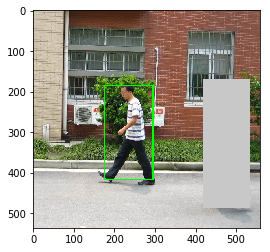

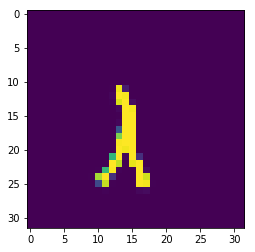

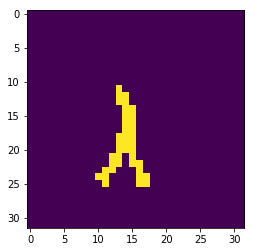

Inference time: 0.5003125667572021
[85, 103, 184, 375]


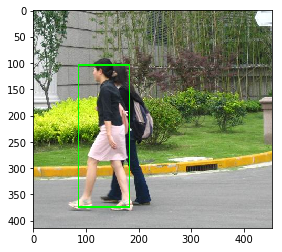

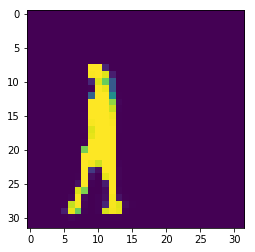

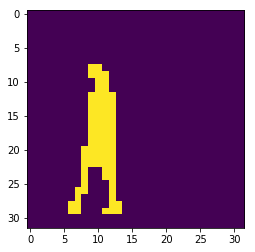

Inference time: 0.5017910003662109
[299, 139, 434, 417]


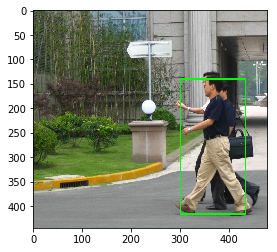

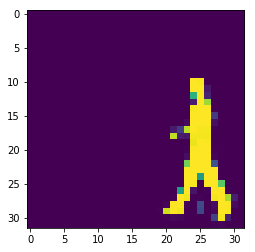

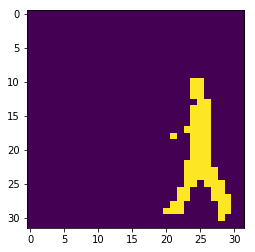

Inference time: 0.4848902225494385
[350, 116, 393, 335]


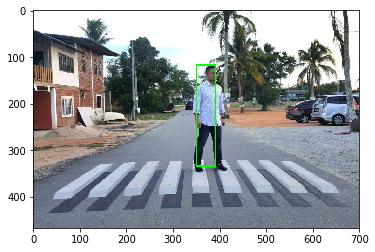

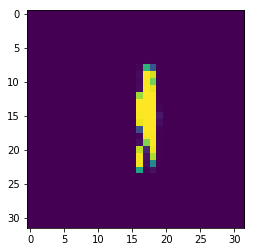

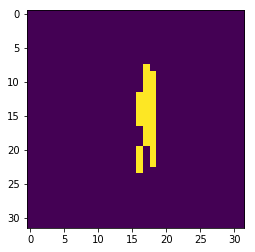

Inference time: 0.5086712837219238
[263, 76, 405, 410]


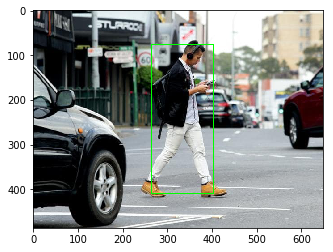

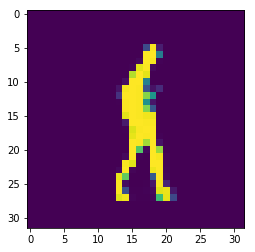

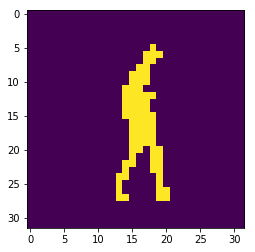

In [0]:
dd = PennFudanGridDataset('./PennFudanPed', None)
test_mask('loc2.pth',MaskLocalizationModel,dd)

test_mask('loc2.pth',MaskLocalizationModel,dd[0][0])
test_mask('loc2.pth',MaskLocalizationModel,dd[1][0])
test_mask('loc2.pth',MaskLocalizationModel,dd[2][0])

test_mask('loc2.pth',MaskLocalizationModel,Image.open('pedastrian.jpg').convert("RGB") )
test_mask('loc2.pth',MaskLocalizationModel,Image.open('pedastrian2.jpg').convert("RGB") )

In [0]:
ls -lah

total 160M
drwxr-xr-x 1 root root 4.0K Sep 14 12:17 ./
drwxr-xr-x 1 root root 4.0K Sep 14 11:20 ../
drwxr-xr-x 1 root root 4.0K Sep  9 16:05 .config/
-rw-r--r-- 1 root root  52M Sep 14 12:37 loc2.pth
-rw-r--r-- 1 root root  57M Sep 14 12:30 loc.pth
-rw-r--r-- 1 root root  38K Sep 14 12:05 pedastrian2.jpg
-rw-r--r-- 1 root root  75K May 28  2018 pedastrian.jpg
drwx------ 5 root root 4.0K Oct 28  2007 PennFudanPed/
-rw-r--r-- 1 root root  52M Oct 28  2007 PennFudanPed.zip
drwxr-xr-x 1 root root 4.0K Aug 27 16:17 sample_data/


## Comparing two models: Position Detection vs Mask Detection

**AVG IoU:** 0.7 vs 0.9

**Training time difference:** 250s vs 275s (10% increase)

**Inference time difference:** 0.4s vs 0.49s (22.5% increase)

**Model weight difference:** 57Mb vs 52Mb

As we see, the mask model is much accurate but training is harder and inference pretty slower. And if we will add few classes with separate masks this will make the model only slower. So developing a solution is always struggling between speed and accuracy.


## Summary and homework

Today we learned two different ways of detection objects on the image, that in future will push us to such networks like YOLO, SDD, Faster-RCNN, Mask-RCNN. We understood the intuition behind a few techniques, and in the real world, good intuition is what makes models work.

### Homework

1.  Use this dataset or similar 
http://www.vision.caltech.edu/visipedia/CUB-200-2011.html </br>
And build two models for position detection and for mask detection, or u can try to merge them in one. (Don't forget to paint over objects if there are more then one on an image like we do in this lecture)
2.  *If we will try to predict more then one object on the image, in the same way as we do for a single object, we will find out that we need somehow make that model prediction predict different objects and not all outputs predict the same one. Also, each output will have a different probability distribution of object presence and if an object will appear everywhere on the image model will not handle this.</br>Think how this problem can be solved without looking on the internet and try to implement it on the Penn-Fudan dataset (for many people on the image)

Questions can be asked here: https://github.com/learnml-today/object-detection-with-pytorch
